
变分高斯玻色采样的训练
======================================


*前置模块*

[关于玻色采样的介绍](https://github.com/TuringQ/deepquantum/tree/main/examples/gbs/boson_sampling/boson_sampling.ipynb)


[关于高斯玻色采样的介绍](https://github.com/TuringQ/deepquantum/tree/main/examples/gbs/gaussian_boson_sampling/gaussian_boson_sampling.ipynb)

引言
------

受到机器学习中神经网络成功的启发，许多应用层面的量子算法依赖于变分量子线路的训练，包括：

1. **量子神经网络（Quantum Neural Networks, QNNs）**：一类模仿经典神经网络结构的量子算法，它们使用可变分的量子网络来表示信息，并利用量子力学原理进行信息处理。

2. **量子支持向量机（Quantum Support Vector Machine, QSVM）**：使用变分量子线路定义核函数，用于解决凸优化、分类问题等。

3. **量子近似优化算法（Quantum Approximate Optimization Algorithm, QAOA）**：通过调整量子线路的参数来找到优化问题的近似最优解。

4. **变分量子本征求解器（Variational Quantum Eigensolver, VQE）**：一种用于求解分子能量基态问题的量子算法，通过训练量子线路的参数来近似哈密顿量的最低本征值。

5. **量子机器学习算法（Quantum Machine Learning Algorithms）**：使用可变分的量子算法来加速机器学习任务，例如量子数据编码、量子特征提取等。

6. **量子随机特征（Quantum Random Feature, QRF）**：将量子计算与经典机器学习模型结合的方法，通过量子线路生成高维空间中的随机特征，以提高模型的性能。

在DeepQuantum常规量子线路中，我们也已经展示了若干从简单、中级到困难的变分量子算法的案例👇

[变分量子算法案例](https://deepquantum.turingq.com/category/quantum-variational-algorithm/)

对于光量子模块，[光量子入门介绍](https://github.com/TuringQ/deepquantum/blob/main/docs/photonic_basics.ipynb) 演示了如何搭建含参数的光量子线路，并用Fock后端进行采样测量。

那么，对于独具特色的高斯玻色采样（Gaussian Boson Sampling，简称GBS）任务，我们是否也能完成对于变分线路的构建和训练呢？




理论基础
------

在[关于高斯玻色采样的介绍](https://github.com/TuringQ/deepquantum/tree/main/examples/gbs/gaussian_boson_sampling/gaussian_boson_sampling.ipynb)中，我们对高斯玻色采样（GBS）进行了细致的介绍。形如[玻色采样](https://github.com/TuringQ/deepquantum/tree/main/examples/gbs/boson_sampling/boson_sampling.ipynb)的概率分布，对于GBS设备，观察到特定输出分布$S$的概率$\Pr(S)$如下：

\begin{equation*}
\Pr(S) = \frac{1}{\mathcal{N}} \frac{|\text{Haf}(A_S)|^2}{s_1!\ldots s_m!},
\end{equation*}

其中，$S=(s_1, s_2, \ldots, s_m)$,  $s_i$是在第$i$个mode探测到的光子数。 
而$\mathcal{N}$ 是一个归一化常数，$A$是一个任意的特征值在 $-1$ 和$1$间的对称矩阵。
矩阵 $A$也可以通过一个常数因子进行重新缩放，相当于定义在目标概率分布中总的平均光子数。

我们希望对这种分布进行**训练**，以执行特定任务。例如，希望再现给定数据集的统计特性，或者优化线路以高概率采样特定模式。以此，任何变分量子算法都有可能在GBS设备上实现。

用数学随机优化模型来表示，给定一个函数$h(S)$和参数$\theta$，我们可以通过采样得到概率分布$P_{\theta}(S)$。而任务的目标则是找到合适的参数$\theta$，来最小化如下期望值：

\begin{equation*}
C (\theta) = \sum_{S} h(S) P_{\theta}(S).
\end{equation*}

此案例将聚焦一个简单的5节点的棒棒糖🍭图。通过变分高斯玻色采样的训练，我们期望在特定的节点观察到尽可能多的光子，而在别的节点观察到尽量少的光子。


完成此变分案例需要以下3步：（i）选用合适的方法编码参数；（ii）调用DeepQuantum模块完成GBS采样模拟；（iii）根据采样结果，选取合适损失函数和优化器完成优化。




问题转化与参数化
-----------------------
我们将会调用DeepQuantum中GBS模块，详情可见[API文档](https://dqapi.turingq.com/deepquantum.photonic.html#deepquantum.photonic.ansatz.GBS_Graph)

首先调用DeepQauntum和相关包：

In [1]:
import deepquantum as dq
import torch

调用networkx包以生成5节点的棒棒糖🍭图，并获得邻接矩阵以对应GBS中特征值在 $-1$ 和$1$间的的对称矩阵$A$。

邻接矩阵A: [[0. 1. 1. 0. 0.]
 [1. 0. 1. 0. 0.]
 [1. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]]


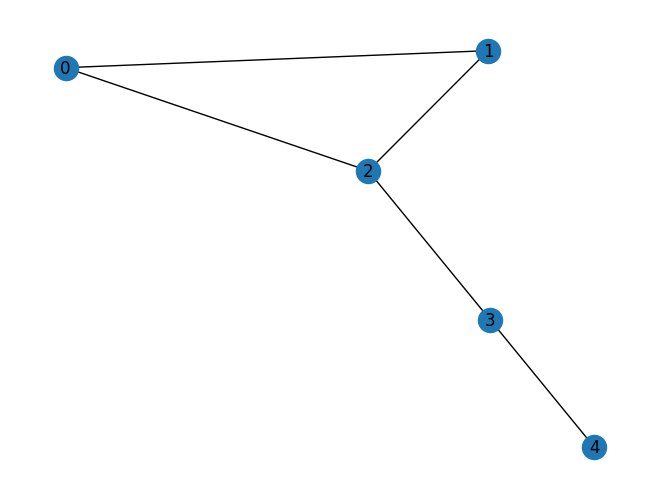

In [15]:
import networkx as nx
import numpy as np

graph = nx.lollipop_graph(3, 2)

# 计算邻接矩阵
a = nx.to_numpy_array(graph)
print('邻接矩阵A:', a)

# 可视化图像
nx.draw(graph, with_labels=True)


此时，若无参数化需要，GBS可通过邻接矩阵$A$采样生成概率分布$P(S)$：

In [3]:
gbs = dq.photonic.ansatz.GBS_Graph(adj_mat=a, cutoff=3, mean_photon_num=6)
gbs()

# 高斯玻色采样
sample = gbs.measure()
print('采样结果为：',sample)

# 计算每个节点理论平均光子数
photon_number = gbs.photon_number_mean_var()[0]
print('每个节点平均光子数为：',photon_number)

chain 5: 100%|█████████████████████████████| 207/207 [00:00<00:00, 13249.42it/s]

采样结果为： {|20200>: 31, |00022>: 13, |00011>: 76, |02200>: 34, |11200>: 35, |11000>: 111, |21100>: 31, |10100>: 84, |01210>: 20, |22000>: 9, |12210>: 11, |01111>: 3, |10111>: 7, |00000>: 317, |10210>: 19, |00220>: 8, |01221>: 6, |00110>: 49, |12221>: 5, |02211>: 2, |22121>: 8, |22011>: 10, |12111>: 7, |11011>: 17, |22211>: 1, |10122>: 5, |11110>: 14, |10021>: 2, |12100>: 25, |01100>: 15, |10221>: 11, |22110>: 2, |11222>: 1, |00121>: 23, |12122>: 1, |11220>: 9, |11211>: 1, |01122>: 1}
每个节点平均光子数为： tensor([1.3273, 1.3273, 2.0721, 0.9466, 0.3268], dtype=torch.float64)


为了实现变分优化，需要编码参数$\theta$进GBS设备，即参数化矩阵$A$。论文[Training Gaussian Boson Sampling Distributions](https://arxiv.org/abs/2004.04770)中引入了“WAW”的参数化方式，即将对称矩阵$A$转化为

\begin{equation*}
A \rightarrow A_W = W A W,
\end{equation*}

其中$W = \text{diag}(\sqrt{w_1}, \sqrt{w_2}, \ldots, \sqrt{w_m})$ 是对角权重矩阵， $m$是GBS模式数。
这样的构造既可以方便的通过权重$w$实现参数化，又保留了$A$对称的特性。另外，在计算$A_W$的hafnian值时，可通过以下分解分离参数化部分，不会额外增加hafnian的计算难度：

\begin{equation*}
\text{Haf}(A_W) = \text{Haf}(A)\text{det}(W),
\end{equation*}

于是，我们可以方便地编码可训练参数$\theta = (\theta_1, \ldots, \theta_d)$ 进权重 $w_k$。这里，我们选用指数嵌入的形式，

\begin{equation*}
w_k = \exp(-\theta_k),
\end{equation*}

In [4]:
# 生成初始参数
nr_modes = len(a)
params = torch.randn(nr_modes,dtype=torch.float64)
print('初始化参数为: ',params)

# 编码进权重矩阵
weights = torch.exp(-params)
print('指数权重为: ',weights)
w = torch.diag(weights)
print('权重矩阵为: ',w)

# 实现WAW参数化
waw = w @ a @ w
print('WAW矩阵为: ',waw)

初始化参数为:  tensor([-1.2884,  0.2127,  0.6615,  1.2599,  0.3656], dtype=torch.float64)
指数权重为:  tensor([3.6271, 0.8084, 0.5161, 0.2837, 0.6938], dtype=torch.float64)
权重矩阵为:  tensor([[3.6271, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8084, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5161, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.2837, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.6938]], dtype=torch.float64)
WAW矩阵为:  tensor([[0.0000, 2.9321, 1.8719, 0.0000, 0.0000],
        [2.9321, 0.0000, 0.4172, 0.0000, 0.0000],
        [1.8719, 0.4172, 0.0000, 0.1464, 0.0000],
        [0.0000, 0.0000, 0.1464, 0.0000, 0.1968],
        [0.0000, 0.0000, 0.0000, 0.1968, 0.0000]], dtype=torch.float64)


调用DeepQuantum模块完成GBS采样模拟
-----------------------
如前模块所示，调用DeepQuantum实现GBS采样模拟十分便捷。高斯玻色采样（GBS）分布由对称矩阵 $A$ 决定，在经过WAW方法参数化后，我们只需要输入waw矩阵。

总的平均光子数是分布的一个超参数：一般而言，不同的选择可能会导致训练中得到不同的结果。实际上，随着权重被优化，平均光子数在训练过程中可能会发生变化，但不会影响最终相对的概率分布。

最后，GBS设备可以操作具有分辨光子数能力的探测器或阈值探测器，这里我们只使用每个模式上的平均光子数。

In [5]:
#根据精度需求设定cutoff
#设定平均光子数为6（也可设置其它）
gbs = dq.photonic.GBS_Graph(adj_mat=waw, cutoff=3,mean_photon_num=6)
gbs()

# 计算每个节点理论平均光子数
photon_number = gbs.photon_number_mean_var()[0]
print('每个节点平均光子数为：',photon_number)

每个节点平均光子数为： tensor([2.9214e+00, 2.1348e+00, 9.3674e-01, 4.7950e-03, 2.3174e-03],
       dtype=torch.float64)


选取损失函数和优化器，完成优化
-----------------------
根据案例开头的需求，在一个5节点的棒棒糖图中，通过变分高斯玻色采样的训练，我们期望在特定的节点观察到尽可能多的光子，而在别的节点观察到尽量少的光子。不失一般性，我们致力于增加棒棒糖图的“糖果”部分中的光子数，这对应于模式子集``[0, 1, 2]``。

损失函数的构建很多样，先采用最简单的线性损失函数：

In [6]:
#构建期望模式子集
subset = [0, 1, 2]

#构建损失函数
def target(s):
    not_subset = [k for k in range(len(s)) if k not in subset]
    return sum(s[not_subset]) - sum(s[subset])

print('loss值为: ',target(photon_number))

loss值为:  tensor(-5.9858, dtype=torch.float64)


接下来仅需通过优化器，最小化损失函数的值，便可完成对于变分高斯玻色采样设备的训练。

为了方便调用优化器，我们整合上面代码，组合成一个`VGBS`的`class`。

In [7]:
import deepquantum as dq
import torch
import networkx as nx
import torch.nn as nn

graph = nx.lollipop_graph(3, 2)
a = nx.to_numpy_array(graph)
nr_modes = len(a)
subset = [0,1,2]
loss_history = []
result = []

class VGBS(nn.Module):

    def __init__(self):
        super(VGBS,self).__init__()
        self.params = nn.Parameter(torch.randn(nr_modes, dtype=torch.float64), requires_grad=False)
        loss_history.clear()

    def target(self,s):
        not_subset = [k for k in range(len(s)) if k not in subset]
        return sum(s[not_subset]) - sum(s[subset])

    def loss(self,x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x).to(self.params.dtype).reshape(-1)
        weights = torch.exp(-x)
        w = torch.diag(weights)
        waw= w @ a @ w

        gbs = dq.photonic.GBS_Graph(adj_mat=waw, cutoff=5,mean_photon_num=6)
        gbs()
        photon_number = gbs.photon_number_mean_var()[0]
        print('每个节点平均光子数为: ',photon_number)
        l = self.target(photon_number)

        loss_history.append(l.item())
        result.clear()
        result.append(photon_number.tolist())

        return l


选取DeepQuantum内建SPSA优化器，设定优化器参数，完成优化。

In [8]:
# 生成刚创建的VGBS模型
model = VGBS()

# 定义优化器参数
spsa_hyperparam = {
    'a': 1,
    'c': 0.01,
    'A': 200,
    'nepoch': 1000,
    'alpha': 0.602,
    'gamma': 0.101
}
optimizer = dq.optimizer.OptimizerSPSA(model.loss, model.params)
optimizer.set_hyperparam(spsa_hyperparam)
param_best = torch.tensor(optimizer.run(100)).float()


每个节点平均光子数为:  tensor([0.2763, 0.1431, 2.9432, 2.6044, 0.0330], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.2769, 0.1341, 2.9431, 2.6126, 0.0332], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.2757, 0.1551, 2.9444, 2.5932, 0.0316], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.2753, 0.1549, 2.9420, 2.5938, 0.0340], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.2843, 0.1548, 2.9450, 2.5850, 0.0309], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.2676, 0.1554, 2.9448, 2.6009, 0.0312], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.3648, 0.1575, 2.9459, 2.5036, 0.0283], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.3427, 0.1475, 2.9453, 2.5335, 0.0309], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.5756, 0.2547, 2.9391, 2.2179, 0.0127], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.6109, 0.2739, 2.9309, 2.1712, 0.0131], dtype=torch.float64)
每个节点平均光子数为:  tensor([1.2362, 0.7007, 2.6733, 1.3744, 0.0154], dtype=torch.float64)
每个节点平均光子数为:  tensor([1.2362, 0.7007, 2.6733, 1.3744, 0.0154], dtype=torch.float64)
每个节点

由优化结果可见，前三个“糖果”节点平均光子数大于“棒子”节点平均光子数，优化成功！



可视化结果
-----------------------
调用`matplotlib`库，绘制优化过程中损失函数随迭代次数下降曲线。
可见在该问题上，虽然使用的是非梯度算法，DeepQuantum自带的`OptimizerSPSA`优化器收敛非常迅速。

Text(0.5, 1.0, 'Loss over time')

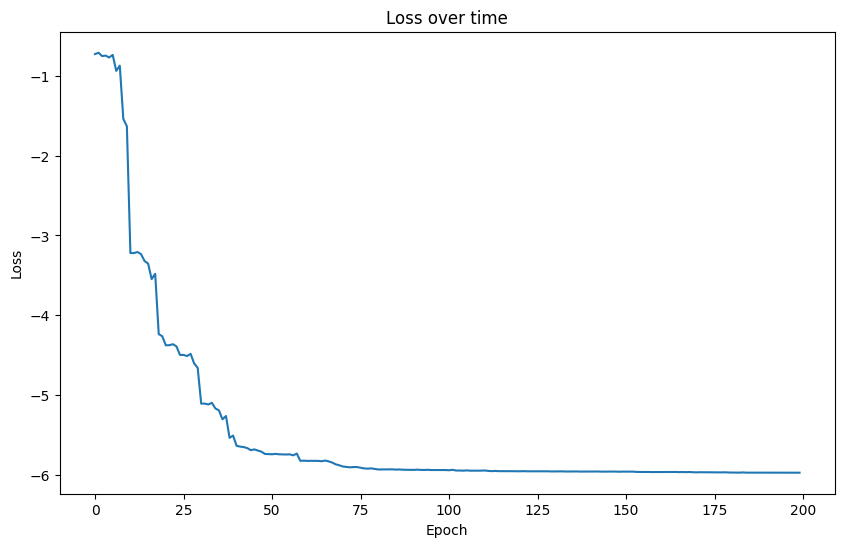

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over time')

绘制棒棒糖图查看变分优化结果。
其中，每个节点的大小代表平均光子数的多少。
明显可见位于“糖果”处的平均光子数远高于“棒子”，实现了本案例训练的目标。

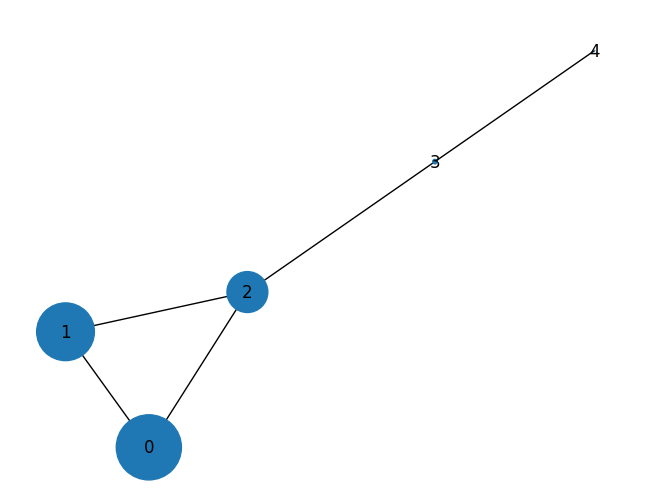

In [10]:
result_scaled = [x * 800 for x in result[0]]
nx.draw(graph, node_size = result_scaled, with_labels=True)

针对损失函数的进一步改进
-----------------------
我们可以观察到，在上个模块中，虽然“糖果”节点处`[0，1，2]`的光子数远高于其它节点，但当前的简单线性损失函数无法很好控制`[0，1，2]`节点的相对光子数。
不失一般性，我们如果额外要求`[0，1，2]`节点的光子数相等，该如何处理？

其实，这项任务本质可以被认为是：训练一个变分高斯采样线路，使其输出的概率分布与目标概率分布相一致。对于概率分布的训练可以通过最小化Kullback-Leibler（KL）散度来执行，这在去掉常数项后可以写成：

\begin{equation*}
KL(\theta) = -\frac{1}{T}\sum_S \log[P_{\theta}(S)].
\end{equation*}


在这种情况下，$ S $ 是概率分布中一个元素，$ P(S) $ 是从GBS分布中抽样时观察到该元素的概率，而 $ T $ 是元素的总数。
据此，我们可以写出新的损失函数`target_kl`:

In [12]:
def target_kl(s):
    return -sum(torch.log(s[subset] / 2))

更新损失函数，再次开始优化：

每个节点平均光子数为:  tensor([0.4071, 1.3318, 2.9669, 1.2893, 0.0050], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.4206, 1.2742, 2.9661, 1.3338, 0.0053], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.3975, 1.3724, 2.9676, 1.2578, 0.0046], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.3974, 1.3721, 2.9673, 1.2581, 0.0050], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.4092, 1.3664, 2.9674, 1.2522, 0.0048], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.3860, 1.3780, 2.9676, 1.2636, 0.0048], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.5791, 1.3028, 2.9663, 1.1478, 0.0040], dtype=torch.float64)
每个节点平均光子数为:  tensor([0.5624, 1.2670, 2.9673, 1.1987, 0.0046], dtype=torch.float64)
每个节点平均光子数为:  tensor([6.8100e-01, 1.5219e+00, 2.9591e+00, 8.3649e-01, 1.4832e-03],
       dtype=torch.float64)
每个节点平均光子数为:  tensor([6.9744e-01, 1.5523e+00, 2.9548e+00, 7.9397e-01, 1.4734e-03],
       dtype=torch.float64)
每个节点平均光子数为:  tensor([7.8542e-01, 1.7020e+00, 2.9249e+00, 5.8627e-01, 1.4007e-03],
       dtype=torch.float64)
每个节点平均

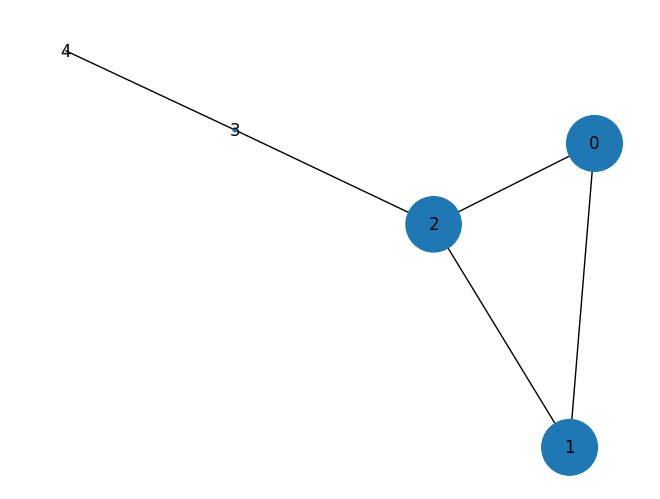

In [14]:
class VGBS(nn.Module):

    def __init__(self):
        super(VGBS,self).__init__()
        self.params = nn.Parameter(torch.randn(nr_modes, dtype=torch.float64), requires_grad=False)
        loss_history.clear()

    # 采用KL散度定义的损失函数    
    def target_kl(self,s):
        return -sum(torch.log(s[subset] / 2))

    def loss(self,x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x).to(self.params.dtype).reshape(-1)
        weights = torch.exp(-x)
        w = torch.diag(weights)
        waw= w @ a @ w

        gbs = dq.photonic.GBS_Graph(adj_mat=waw, cutoff=5,mean_photon_num=6)
        gbs()
        photon_number = gbs.photon_number_mean_var()[0]
        print('每个节点平均光子数为: ',photon_number)
        l = self.target_kl(photon_number)

        loss_history.append(l.item())
        result.clear()
        result.append(photon_number.tolist())

        return l
    
model = VGBS()
loss_history = []

# 定义优化器参数
spsa_hyperparam = {
    'a': 1,
    'c': 0.01,
    'A': 200,
    'nepoch': 1000,
    'alpha': 0.602,
    'gamma': 0.101
}
optimizer = dq.optimizer.OptimizerSPSA(model.loss, model.params)
optimizer.set_hyperparam(spsa_hyperparam)
param_best = torch.tensor(optimizer.run(1000)).float()

result_scaled = [x * 800 for x in result[0]]
nx.draw(graph, node_size = result_scaled, with_labels=True)

每个“糖果”节点输出近似2个光子，而其余节点几乎没有输出光子，优化结果非常完美！

# 附录

[1] Leonardo Banchi, Nicolás Quesada, and Juan Miguel Arrazola. Training Gaussian Boson Sampling Distributions. arXiv:2004.04770. 2020.